In [41]:
import matplotlib.pyplot as plt
import nltk
import numpy as np
import pandas as pd
import sklearn
import warnings

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import utils
import ml_functions
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn import (
    linear_model, 
    ensemble,
    tree,
    decomposition, 
    naive_bayes, 
    neural_network,
    svm,
    metrics,
    preprocessing, 
    model_selection, 
    pipeline,
)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, learning_curve
import warnings
from sklearn.exceptions import ConvergenceWarning
from imblearn.pipeline import make_pipeline as make_imb_pipeline
warnings.filterwarnings("ignore", category=ConvergenceWarning)

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import PrecisionRecallDisplay
from tqdm import tqdm
from time import time
from sklearn.model_selection import StratifiedKFold, LeaveOneOut, cross_val_score
from sklearn.svm import LinearSVC
from sklearn.model_selection import LearningCurveDisplay, ShuffleSplit

## Load the data & Préprocessing

In [2]:
fname = "./datasets/AFDpresidentutf8/corpus.tache1.learn.utf8"
alltxts,alllabs = utils.load_pres(fname)


In [3]:
locuteurs_df = pd.DataFrame()
locuteurs_df['text'] = alltxts
locuteurs_df['label'] = alllabs

In [4]:
preprocessed_alltxts = [utils.preprocess(alltxt) for alltxt in locuteurs_df.text]

preprocessed_locuteurs_df = pd.DataFrame()
preprocessed_locuteurs_df['text'] = preprocessed_alltxts
preprocessed_locuteurs_df['label'] = alllabs

preprocessed_locuteurs_df.describe


<bound method NDFrame.describe of                                                     text  label
0       quand je dis chers amis il ne sagit pas la du...      1
1       dabord merci de cet exceptionnel accueil que ...      1
2       cest toujours tres emouvant de venir en afriq...      1
3       aucun citoyen francais ne peut etre indiffere...      1
4       le congo que naguere le nom qualifia de refug...      1
...                                                  ...    ...
57408              je suis heureux de le mener avec vous      1
57409   vous le savez comme vous jai la passion de la...      1
57410                             je crois en son avenir      1
57411   je crois en la politique cestadire en notre c...      1
57412                                 je compte sur vous      1

[57413 rows x 2 columns]>

In [5]:
# Mélange des données
preprocessed_locuteurs_df = preprocessed_locuteurs_df.sample(frac=1, random_state=42)

preprocessed_locuteurs_df.describe

<bound method NDFrame.describe of                                                     text  label
45008   de mener a bien dans lequite dans le dialogue...      1
5011                            tout cela nest pas exact      1
31032   cest tout le merite du maitre douvrage et des...      1
31493   a lenraciner dans les esprits et dans les coeurs      1
1270    nos deux pays qui travaillent la main dans la...      1
...                                                  ...    ...
54343   et puis nous devons egalement etre porteurs d...      1
38158                      il les impose trop lourdement      1
860                         dautres figures lont marquee      1
15795   avec le gouvernement que jai constitue et qui...     -1
56422   il faut dabord examiner les problemes du cont...     -1

[57413 rows x 2 columns]>

In [6]:
print(len(preprocessed_locuteurs_df['text']))
print(len(preprocessed_locuteurs_df['label']))

57413
57413


In [13]:
X, X_test, y, y_test = model_selection.train_test_split(preprocessed_locuteurs_df['text'], preprocessed_locuteurs_df['label'], test_size=0.2, random_state=24, stratify= preprocessed_locuteurs_df['label'])

# Etude de la cross validation 

In [21]:
def make_pipeline(mode, model):
    if mode == "original":
        return make_imb_pipeline(CountVectorizer(), model())
    elif mode == "oversampling":
        return make_imb_pipeline(CountVectorizer(), RandomOverSampler(), model())
    elif mode == "undersampling":
        return make_imb_pipeline(
            CountVectorizer(), RandomUnderSampler(replacement=False), model()
        )
    elif mode == "regularization" and model.__name__ != "MultinomialNB":
        return make_imb_pipeline(CountVectorizer(), model(class_weight="balanced"))
    elif "regularization" in mode and model.__name__ == "MultinomialNB":
        return make_imb_pipeline(CountVectorizer(), model(fit_prior=True))

In [22]:
pipeline = make_pipeline("original", LogisticRegression)

# ideal = np.mean(cross_val_score(pipeline, X, y, scoring='accuracy', cv=LeaveOneOut(), n_jobs=-1))
# define folds to test
folds = range(2, 31)
# record mean and min/max of each set of results
means, mins, maxs, times = list(), list(), list(), list()
# evaluate each k value
for k in tqdm(folds):
    # define the test condition
    t = time()
    cv = StratifiedKFold(n_splits=k, shuffle=True, random_state=1)
    # evaluate k value
    scores = cross_val_score(pipeline, X, y, scoring="roc_auc", cv=cv, n_jobs=-1)
    times.append(time() - t)
    k_mean, k_min, k_max = np.mean(scores), scores.min(), scores.max()
    # report performance
    print("folds=%d, accuracy=%.3f (%.3f,%.3f)" % (k, k_mean, k_min, k_max))
    # store mean accuracy
    means.append(k_mean)
    # store min and max relative to the mean
    mins.append(k_mean - k_min)
    maxs.append(k_max - k_mean)

  3%|▎         | 1/29 [00:02<01:17,  2.77s/it]

> folds=2, accuracy=0.850 (0.849,0.851)


  7%|▋         | 2/29 [00:05<01:06,  2.47s/it]

> folds=3, accuracy=0.858 (0.853,0.861)


 10%|█         | 3/29 [00:07<01:03,  2.44s/it]

> folds=4, accuracy=0.862 (0.860,0.866)


 14%|█▍        | 4/29 [00:09<01:01,  2.45s/it]

> folds=5, accuracy=0.864 (0.860,0.870)


 17%|█▋        | 5/29 [00:11<00:54,  2.27s/it]

> folds=6, accuracy=0.866 (0.856,0.871)


 21%|██        | 6/29 [00:13<00:49,  2.17s/it]

> folds=7, accuracy=0.867 (0.857,0.876)


 24%|██▍       | 7/29 [00:16<00:48,  2.21s/it]

> folds=8, accuracy=0.867 (0.853,0.881)


 28%|██▊       | 8/29 [00:18<00:48,  2.29s/it]

> folds=9, accuracy=0.868 (0.856,0.883)


 31%|███       | 9/29 [00:21<00:48,  2.42s/it]

> folds=10, accuracy=0.868 (0.853,0.879)


 34%|███▍      | 10/29 [00:24<00:49,  2.61s/it]

> folds=11, accuracy=0.868 (0.852,0.882)


 38%|███▊      | 11/29 [00:27<00:51,  2.84s/it]

> folds=12, accuracy=0.869 (0.850,0.887)


 41%|████▏     | 12/29 [00:31<00:55,  3.24s/it]

> folds=13, accuracy=0.870 (0.851,0.888)


 45%|████▍     | 13/29 [00:35<00:56,  3.50s/it]

> folds=14, accuracy=0.869 (0.845,0.883)


 48%|████▊     | 14/29 [00:40<00:57,  3.82s/it]

> folds=15, accuracy=0.869 (0.851,0.891)


 52%|█████▏    | 15/29 [00:44<00:56,  4.01s/it]

> folds=16, accuracy=0.869 (0.838,0.889)


 55%|█████▌    | 16/29 [00:49<00:54,  4.17s/it]

> folds=17, accuracy=0.869 (0.848,0.889)


 59%|█████▊    | 17/29 [00:53<00:51,  4.28s/it]

> folds=18, accuracy=0.870 (0.841,0.901)


 62%|██████▏   | 18/29 [00:58<00:48,  4.43s/it]

> folds=19, accuracy=0.870 (0.847,0.894)


 66%|██████▌   | 19/29 [01:03<00:45,  4.54s/it]

> folds=20, accuracy=0.870 (0.845,0.886)


 69%|██████▉   | 20/29 [01:08<00:42,  4.70s/it]

> folds=21, accuracy=0.870 (0.834,0.905)


 72%|███████▏  | 21/29 [01:13<00:38,  4.85s/it]

> folds=22, accuracy=0.870 (0.850,0.892)


 76%|███████▌  | 22/29 [01:19<00:35,  5.07s/it]

> folds=23, accuracy=0.870 (0.825,0.896)


 79%|███████▉  | 23/29 [01:25<00:32,  5.34s/it]

> folds=24, accuracy=0.870 (0.845,0.907)


 83%|████████▎ | 24/29 [01:32<00:28,  5.74s/it]

> folds=25, accuracy=0.870 (0.822,0.895)


 86%|████████▌ | 25/29 [01:38<00:24,  6.06s/it]

> folds=26, accuracy=0.870 (0.841,0.899)


 90%|████████▉ | 26/29 [01:46<00:19,  6.42s/it]

> folds=27, accuracy=0.870 (0.829,0.908)


 93%|█████████▎| 27/29 [01:53<00:13,  6.79s/it]

> folds=28, accuracy=0.870 (0.833,0.899)


 97%|█████████▋| 28/29 [02:01<00:07,  7.12s/it]

> folds=29, accuracy=0.870 (0.830,0.900)


100%|██████████| 29/29 [02:09<00:00,  4.46s/it]

> folds=30, accuracy=0.870 (0.827,0.909)


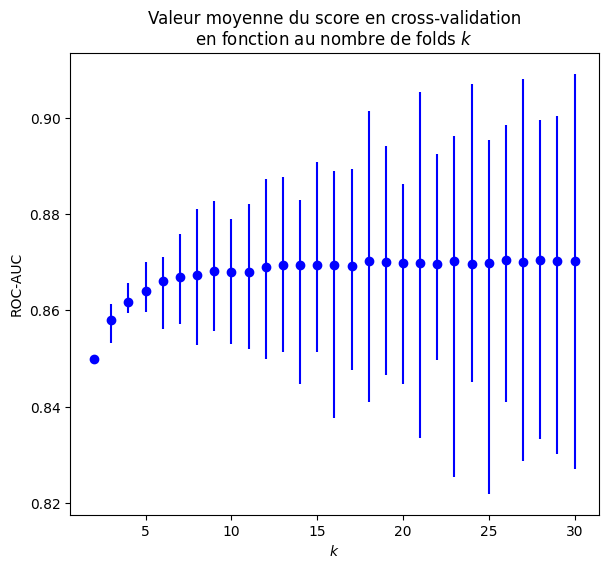

In [27]:
# Tracé du premier graphique avec les barres d'erreur
plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.errorbar(folds, means, yerr=[mins, maxs], fmt="o", color="blue")  # Modification de la couleur
plt.xlabel("$k$")
plt.ylabel("ROC-AUC")
plt.title("Valeur moyenne du score en cross-validation\nen fonction au nombre de folds $k$")
plt.show()

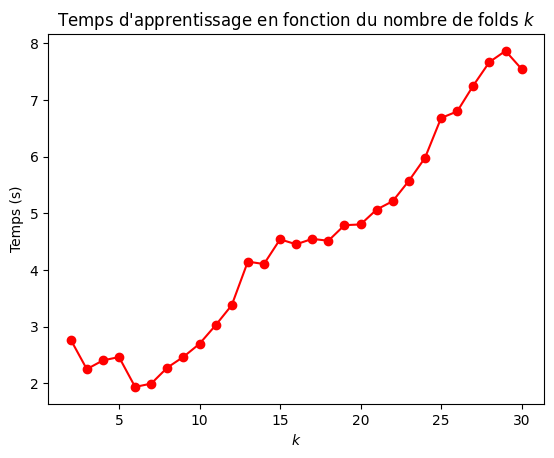

In [35]:
plt.plot(folds, times, "r-o")
plt.xlabel("$k$")
plt.ylabel("Temps (s)")
plt.title("Temps d'apprentissage en fonction du nombre de folds $k$")

plt.show()